<a href="https://colab.research.google.com/github/HardeepSaggu/TVShow-Recommendation-System-NLP/blob/master/TVShow_Recommender_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**libraries and modules**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity,cosine_similarity,linear_kernel
from ast import literal_eval
import warnings
from scipy.sparse import csr_matrix
warnings.filterwarnings('ignore')
%matplotlib inline

**Dataset** 


In [2]:
df2 = pd.read_csv('C:/Programming/Python/Movie-Recommendation-System-NLP-master/tmdb-movie-metadata/TMDB_tv_dataset_v3.csv')

In [3]:
df2.head(5)

,id,name,number_of_seasons,number_of_episodes,original_language,vote_count,vote_average,overview,adult,backdrop_path,...,tagline,genres,created_by,languages,networks,origin_country,spoken_languages,production_companies,production_countries,episode_run_time
0,1399,Game of Thrones,8,73,en,21857,8.442,Seven noble families fight for control of the ...,False,/2OMB0ynKlyIenMJWI2Dy9IWT4c.jpg,...,Winter Is Coming,"Sci-Fi & Fantasy, Drama, Action & Adventure","David Benioff, D.B. Weiss",en,HBO,US,English,"Revolution Sun Studios, Television 360, Genera...","United Kingdom, United States of America",0
1,71446,Money Heist,3,41,es,17836,8.257,"To carry out the biggest heist in history, a m...",False,/gFZriCkpJYsApPZEF3jhxL4yLzG.jpg,...,The perfect robbery.,"Crime, Drama",Álex Pina,es,"Netflix, Antena 3",ES,Español,Vancouver Media,Spain,70
2,66732,Stranger Things,4,34,en,16161,8.624,"When a young boy vanishes, a small town uncove...",False,/2MaumbgBlW1NoPo3ZJO38A6v7OS.jpg,...,Every ending has a beginning.,"Drama, Sci-Fi & Fantasy, Mystery","Matt Duffer, Ross Duffer",en,Netflix,US,English,"21 Laps Entertainment, Monkey Massacre Product...",United States of America,0
3,1402,The Walking Dead,11,177,en,15432,8.121,Sheriff's deputy Rick Grimes awakens from a co...,False,/x4salpjB11umlUOltfNvSSrjSXm.jpg,...,Fight the dead. Fear the living.,"Action & Adventure, Drama, Sci-Fi & Fantasy",Frank Darabont,en,AMC,US,English,"AMC Studios, Circle of Confusion, Valhalla Mot...",United States of America,42
4,63174,Lucifer,6,93,en,13870,8.486,"Bored and unhappy as the Lord of Hell, Lucifer...",False,/aDBRtunw49UF4XmqfyNuD9nlYIu.jpg,...,It's good to be bad.,"Crime, Sci-Fi & Fantasy",Tom Kapinos,en,"FOX, Netflix",US,English,"Warner Bros. Television, DC Entertainment, Jer...",United States of America,45


**Merging both datasets to one to combine everything into one main DataFrame using 'id' feature**


In [4]:
m = df2['vote_count'].quantile(0.9)
C = df2['vote_average'].mean()

In [5]:
def weight_average(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m))*R + (m/(v+m))*C

**Filtering Dataframe to get tvshows with vote count >= m (minimum votes required to appear on chart)**

In [6]:
q_tvshows = df2.copy().loc[df2['vote_count'] >= m]
q_tvshows.shape

(18585, 29)

In [7]:
q_tvshows['score'] = q_tvshows.apply(weight_average , axis = 1)
q_tvshows.shape

(18585, 30)

**find top 10 IMDB rated tvshows**

In [8]:
q_tvshows = q_tvshows.sort_values('score' , ascending = False)
q_tvshows[['name','vote_average','vote_count']].head(10)

,name,vote_average,vote_count
3245,Adventure Time: Fionna & Cake,9.478,90
5795,Scooby-Doo!: Behind the Scenes,10.000,34
5151,On Air with Ryan Seacrest,9.700,41
7,Breaking Bad,8.890,12398
85,Arcane,8.740,3341
60,One Piece,8.725,4052
21,Rick and Morty,8.700,8595
34,Demon Slayer: Kimetsu no Yaiba,8.700,5618
51,Anne with an E,8.696,4383
77,Avatar: The Last Airbender,8.690,3497


Text(0.5, 1.0, 'Popular TVShows')

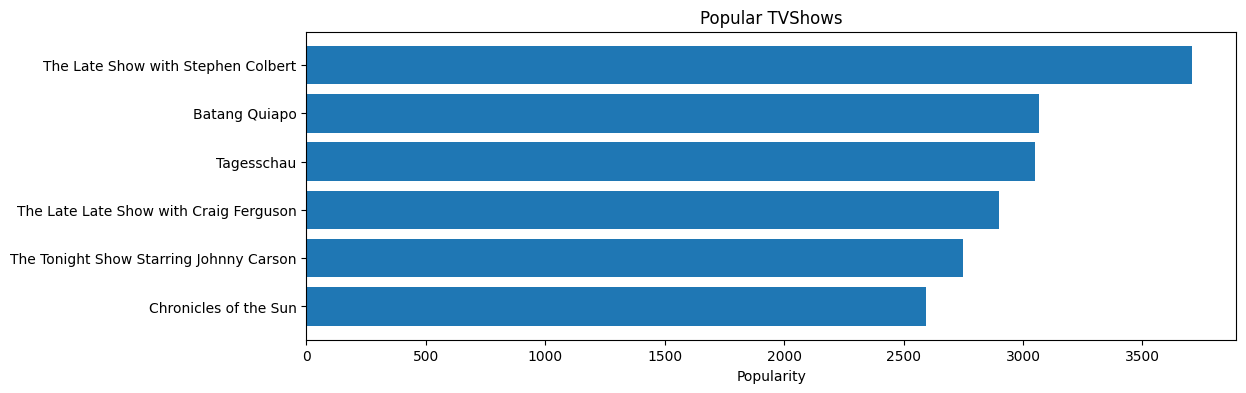

In [9]:
pop = df2.sort_values('popularity' , ascending = False)
plt.figure(figsize=(12,4))
plt.barh(pop['name'].head(6),pop['popularity'].head(6))
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Popular TVShows")

**Content Based Filtering**

## Initializing TDF-IDF vectorizer object to generate TDF-IDF matrix of plots of tvshows

---

In [10]:
tfidf = TfidfVectorizer( stop_words='english' )
df2['overview'] = df2['overview'].fillna('')
tfidf_matrix = tfidf.fit_transform(df2['overview'])
tfidf_matrix_sparse = csr_matrix(tfidf_matrix)
tfidf_matrix_sparse.shape

(168639, 132976)

In [11]:
tfidf_matrix_subset = tfidf_matrix[:70000]
cosine_sim = linear_kernel(tfidf_matrix_subset, tfidf_matrix_subset)
cosine_sim.shape

MemoryError: Unable to allocate 74.5 GiB for an array with shape (100000, 100000) and data type float64

In [ ]:
indices = pd.Series(df2.index, index=df2['name']).drop_duplicates()
def get_recommendations(title,cosine_sim = cosine_sim):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    tvshow_indices = [i[0] for i in sim_scores]
    return df2['name'].iloc[tvshow_indices]

**Testing recommender System**

In [ ]:
get_recommendations('How I Met Your Mother')

IndexError: index 20867 is out of bounds for axis 0 with size 10000